# 3.1.2 Conjuntos de entrenamiento y prueba

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

## 3.1.2.1 Generación de los datos del experimiento

In [3]:
#
# Función a aproximar
# (Proceso geneador de datos)
#
def f(x):
    return 2 * np.abs(np.sin(x * np.pi / 4 + 0.75)) / (1 + 0.1 * x)

#
# Datos reales.
# (No disponibles en la realidad)
#
x_real = np.linspace(0, 10, 100)
x_real = x_real[:, np.newaxis]
y_real = f(x_real)

In [4]:
#
# Muestra de datos.
# (Información disponible en la realidad)
#
rng = np.random.default_rng(12345)

x_sample = np.linspace(0, 10, 100)
rng.shuffle(x_sample)
x_sample = x_sample[:20]
x_sample = np.sort(x_sample)

y_sample = f(x_sample)
X_sample = x_sample[:, np.newaxis]

## 3.1.2.2 Muestras en entrenamiento y prueba

- La generalización del modelo debe estimarse a partir de los datos disponibles.
- Los datos disponibles se dividen en dos conjuntos: uno para ajuste de parámetros del modelo y otro para medir la generalización.
- La totalidad de la información es usada para determinar el grado óptimo del polinómio y sus coeficientes.
- Esta aproximación es usada en TensorFlow

In [5]:
from sklearn.model_selection import train_test_split

#
# Se usan 20 ejemplos para entrenamiento del modelo y los 5 restantes
# para medir la generalización.
#
X_train, X_test, y_train_true, y_test_true = train_test_split(
    # --------------------------------------------------------------------------
    # Los primeros train_size ejemplos son asignados al conjunto de
    # entrenamiento. Del resto de la muestra, los primeros test_size son
    # asignados a la muestra de prueba
    X_sample,
    y_sample,
    # --------------------------------------------------------------------------
    # Tamaño de la muestra de prueba.
    # int: indica la cantidad de muestras
    # float: indica el porcentaje y debe estar entre 0.0 y 1.0
    test_size=5,
    # --------------------------------------------------------------------------
    # Tamaño de la muestra de entrenamiento.
    # int: indica la cantidad de muestras
    # float: indica el porcentaje y debe estar entre 0.0 y 1.0
    train_size=None,
    # --------------------------------------------------------------------------
    # Semilla del generador aleatorio
    random_state=12345,
    # --------------------------------------------------------------------------
    # Mezcla los ejemplos antes de hacer la partición
    shuffle=True,
)

## 3.1.2.3 Evaluación para la muestra de datos disponible

In [6]:
degrees = list(range(1, 21))

mse_train = []
mse_test = []

for i_degree, degree in enumerate(degrees):

    model = make_pipeline(
        PolynomialFeatures(degree, include_bias=False),
        MinMaxScaler(),
        LinearRegression(),
    )
    model.fit(X_train, y_train_true)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    mse_train.append(mean_squared_error(y_train_true, y_train_pred))
    mse_test.append(mean_squared_error(y_test_true, y_test_pred))


df = pd.DataFrame(
    {
        "Degree": degrees,
        "MSE train": mse_train,
        "MSE test": mse_test,
    }
).sort_values("MSE test", ascending=True)

df

,Degree,MSE train,MSE test
7,8,2.646114e-03,0.010575
8,9,2.605522e-03,0.012065
10,11,4.724010e-04,0.051601
6,7,3.304064e-02,0.068749
5,6,3.442220e-02,0.081348
9,10,1.087721e-03,0.081453
1,2,1.002132e-01,0.136885
11,12,5.617338e-05,0.139212
0,1,1.244092e-01,0.141053
12,13,7.821378e-08,0.210838


In [7]:
#
# Grado óptimo del polinomio
#
df.Degree.iloc[0]

8

## 3.1.2.4 Pronóstico con el mejor modelo encontrado

In [8]:
optimal_degree = df.Degree.iloc[0]

model = make_pipeline(
    PolynomialFeatures(optimal_degree, include_bias=False),
    MinMaxScaler(),
    LinearRegression(),
)

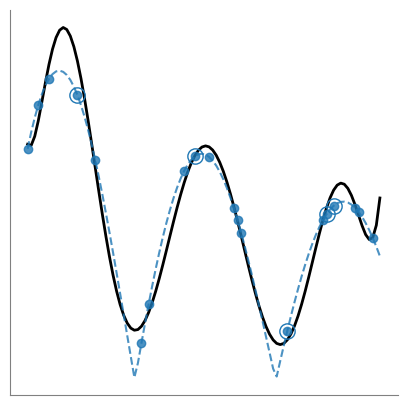

In [10]:
#
# Opción 1: Modelo óptimo entrenado solo con la muestra de
#   entrenamiento.
#
model.fit(X_train, y_train_true)

y_pred = model.predict(x_real)

plt.figure(figsize=(5, 5))
plt.plot(x_real, y_real, "--", color="tab:blue", alpha=0.8, zorder=10)
plt.plot(x_sample, y_sample, "o", color="tab:blue", alpha=0.8, zorder=10)
plt.plot(
    X_test,
    y_test_true,
    "o",
    color="tab:blue",
    alpha=1.0,
    zorder=10,
    markersize=11,
    fillstyle="none",
)

plt.plot(
    x_real,
    y_pred,
    color="black",
    linewidth=2,
)

plt.xticks([], [])
plt.yticks([], [])

plt.gca().spines["left"].set_color("gray")
plt.gca().spines["bottom"].set_color("gray")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.show()

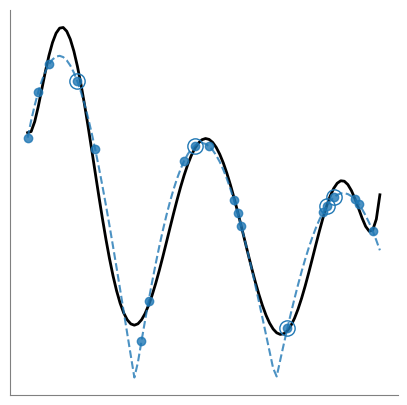

In [12]:
#
# Opción 2: Modelo óptimo entrenado con la totalidad de
#   la muestra.
#
model.fit(X_sample, y_sample)

y_pred = model.predict(x_real)

plt.figure(figsize=(5, 5))
plt.plot(x_real, y_real, "--", color="tab:blue", alpha=0.8, zorder=10)
plt.plot(x_sample, y_sample, "o", color="tab:blue", alpha=0.8, zorder=10)
plt.plot(
    X_test,
    y_test_true,
    "o",
    color="tab:blue",
    alpha=1.0,
    zorder=10,
    markersize=11,
    fillstyle="none",
)

plt.plot(
    x_real,
    y_pred,
    color="black",
    linewidth=2,
)

plt.xticks([], [])
plt.yticks([], [])

plt.gca().spines["left"].set_color("gray")
plt.gca().spines["bottom"].set_color("gray")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.show()

In [32]:
print('ok_')

ok_
